# Look at snr properties

In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_latest w_2022_07 setup
obs_vista             23.0.0-1   	current setup


In [2]:
import numpy as np
from scipy import stats

from collections import OrderedDict

from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
import astropy.units as u
from astropy import visualization as vz


import os
from collections import OrderedDict
import yaml
import glob
import numpy as np


import matplotlib
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
%matplotlib inline

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

import warnings
warnings.filterwarnings('ignore')

import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

from lsst.afw.image import abMagFromFlux, abMagErrFromFluxErr, fluxFromABMag, fluxErrFromABMagErr

In [12]:
!ls ./data/

3.0_startCoadd.slurm.e58711243
39
48
66
8523_5,2_reducedCat.fits
VSA_Ks_6.fits
calexp-HSC-R-8524-2,7.fits
calexp-VISTA-Y-8524-2,7.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220405T133706Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoadd_20220411T145237Z.fits
example
full_reduced_cat_SXDS_p2021_1.fits
full_reduced_cat_SXDS_p2021_1_20210702.fits
full_reduced_cat_SXDS_p2022.1_20220428.fits
full_reduced_cat_SXDS_p2022.1_20220721.fits.gz
u_ir-shir1_DRP_singleFrame_20220317T193549Z_2022-03-17_21:12.png
u_ir-shir1_DRP_videoCoadd_20220407T164547Z_2022-04-07_18:40.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-11_16:55.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-13_16:09.png
u_ir-shir1_DRP_videoMultiVisit3_20220420T134201Z_2022-04-20_14:49.png


In [13]:
tab=Table.read('./data/full_reduced_cat_SXDS_p2022.1_20220721.fits.gz')

In [25]:
for c in tab.colnames:
    tab[c]=tab[c].flatten()

In [26]:
tab[:5]

ID,HSC_G_M_COORD_RA,HSC_G_M_COORD_DEC,HSC_G_M_PARENT,HSC_G_M_MERGE_PEAK_HSC_I,HSC_G_M_MERGE_PEAK_HSC_R,HSC_G_M_MERGE_PEAK_HSC_Z,HSC_G_M_MERGE_PEAK_HSC_Y,HSC_G_M_MERGE_PEAK_HSC_G,HSC_G_M_MERGE_PEAK_VISTA_Z,HSC_G_M_MERGE_PEAK_VISTA_Y,HSC_G_M_MERGE_PEAK_VISTA_J,HSC_G_M_MERGE_PEAK_VISTA_H,HSC_G_M_MERGE_PEAK_VISTA_KS,HSC_G_M_MERGE_PEAK_SKY,HSC_G_M_DEBLEND_NCHILD,HSC_G_M_DETECT_ISPRIMARY,HSC_G_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,HSC_G_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,HSC_R_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,HSC_R_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,HSC_I_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,HSC_I_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,HSC_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,HSC_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,HSC_Y_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,HSC_Y_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,VISTA_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,VISTA_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,VISTA_Y_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,VISTA_Y_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,VISTA_J_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,VISTA_J_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,VISTA_H_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,VISTA_H_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR,VISTA_K_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG,VISTA_K_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR
int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int16,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
149938304735799380,0.6090752524678374,-0.08341930565178861,149938304735779631,True,True,True,False,True,False,True,False,False,False,False,0,True,26.18819989544217,0.1685946856661647,25.557581143068703,0.17096062607491952,25.888252757424475,0.23677283860848156,25.167246231794856,0.2864396895954862,26.441342402793868,2.0662755003915283,26.495862243850617,0.10848501978540931,26.304284642097464,0.14303201842971763,27.223749952040592,0.6095310392951893,0.0,1.4344821923271656,25.264503714606338,0.21514217465295024
149938304735799648,0.6113132923317934,-0.08333614008374352,149938304735779851,True,True,True,True,True,True,True,True,True,True,False,0,False,24.769885535879737,0.04250345579031589,24.78741923239419,0.07340891834212251,24.171847292205268,0.039716213725861864,24.050934482287087,0.09028582842083327,23.598403153296225,0.12697420188626238,24.323352405262945,0.021866461894437913,24.429029446328787,0.021117753966969525,24.200489749212643,0.03041436490610703,24.456215848679083,0.04698010356998578,24.06660879840493,0.054951277976038646
149938304735799677,0.6095745838310362,-0.08317508769749864,149938304735779868,True,True,False,False,False,False,False,False,False,False,False,0,True,21.63369958594368,0.0058865014127748635,19.960252501841097,0.004394912002938156,20.4364372697827,0.0029220546141811594,20.053968225793874,0.0051091366211119815,20.259894995990656,0.00946650715704604,19.549871739986372,0.00028110519231927165,19.573730876405417,0.0002739182514128919,19.587908304113263,0.0004690196753287256,19.939529343739988,0.0007942882465954207,20.358019964751,0.0018898920876971952
149938304735799710,0.609559296732507,-0.08323683298587149,149938304735779868,True,True,False,False,False,False,False,False,False,False,False,0,True,25.948655348518535,0.1704387550383229,25.320321292792336,0.15782976825722514,26.002835859132496,0.23142161894572122,24.982957370010354,0.2196573707705365,0.0,770.1884196705716,28.134585799449134,0.49228112156482157,27.5341028893062,0.3763070757956036,26.040059857806103,0.17631605573423095,26.52378941268381,0.3657634937383481,24.713159321710222,0.10982281932117563
149938304735799730,0.6092340457676271,-0.08329548833552873,149938304735779896,True,True,True,True,True,True,True,True,False,False,False,0,True,26.011549797762605,0.14871688041274375,25.457138589272674,0.15869700823482008,24.968886089040137,0.09039971399827665,24.59341257073359,0.1489146761160662,25.076370723260762,0.5180017133370366,25.13291964233214,0.03

In [110]:


f=fluxFromABMag(np.array(tab['HSC_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'].value.tolist()))
ferr=fluxErrFromABMagErr(
    np.array(tab['HSC_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR'].value.tolist()),
    np.array(tab['HSC_Z_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'].value.tolist()),
)

Text(0.5, 0, 'Log10(SNR)')

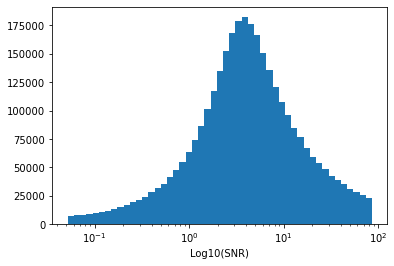

In [133]:
snr=f/ferr
m=np.isfinite(f/ferr)


logbins = np.logspace(np.log10(np.percentile(snr[m],5)),np.log10(np.percentile(snr[m],95)),50)
plt.hist(snr[m],bins=logbins)
plt.xscale('log')
plt.xlabel('Log10(SNR)')

In [138]:
len(snr),len(tab)

(3607923, 3607923)

In [144]:
fracs=Table()
fracs['snr_bins']=logbins[:-1]
for s in 'grizyZYJHK':
    if s.islower():
        band='HSC_'+s.upper()
    else:
        band='VISTA_'+s.replace('K','KS')
    print(band)
    fracs[band]=[np.sum(tab['HSC_G_M_MERGE_PEAK_{}'.format(band)][
        (snr>logbins[n])&(snr<logbins[n+1])
    ])/np.sum((snr>logbins[n])&(snr<logbins[n+1])) 
                 for n in np.arange(len(logbins[:-1]))
                ]

HSC_G
HSC_R
HSC_I
HSC_Z
HSC_Y
VISTA_Z
VISTA_Y
VISTA_J
VISTA_H
VISTA_KS


In [146]:
fracs[:5]

snr_bins,HSC_G,HSC_R,HSC_I,HSC_Z,HSC_Y,VISTA_Z,VISTA_Y,VISTA_J,VISTA_H,VISTA_KS
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.051948813613873095,0.36440554339897885,0.11305616338439095,0.42509117432531,0.0032093362509117433,0.07104303428154632,0.027133479212253828,0.030342815463165574,0.02975929978118162,0.06301969365426696,0.07571115973741795
0.06042804210462036,0.34718179412543,0.122254564699656,0.4329187615771368,0.003440063508864779,0.07475522625033078,0.02990209050013231,0.0316221222545647,0.028446679015612597,0.06575813707329982,0.06840433977242656
0.07029127363213958,0.34905201750121534,0.12348079727758872,0.4347350510452115,0.0024307243558580457,0.08021390374331551,0.030140982012639768,0.03135634419056879,0.027953330092367525,0.06161886242100146,0.07024793388429752
0.08176440898538627,0.3402692778457772,0.11394236118838322,0.4620006676310226,0.0020028930677645487,0.07210415043952376,0.02781795927450762,0.03449426950038945,0.029264493156782017,0.06520529653944587,0.06476020919105374
0.09511022110250557,0.3452186350633429,0.11626481405803024,0.4651614221495709,0.004393134450347364,0.08142623620760114,0.027278299959133633,0.03473641193297916,0.02748263179403351,0.06293420514916225,0.06334286881896199


In [196]:
colordict={}
colors=["red", "orange", "yellow", "green", "blue", "indigo", "violet", "violet", "violet", "violet"]
for n,s in enumerate('grizyZYJHK'):
    n=len('grizyZYJHK')-n-1
    colordict[s]=colors[n]

In [197]:
colordict

{'g': 'violet',
 'r': 'violet',
 'i': 'violet',
 'z': 'violet',
 'y': 'indigo',
 'Z': 'blue',
 'Y': 'green',
 'J': 'yellow',
 'H': 'orange',
 'K': 'red'}

HSC_G


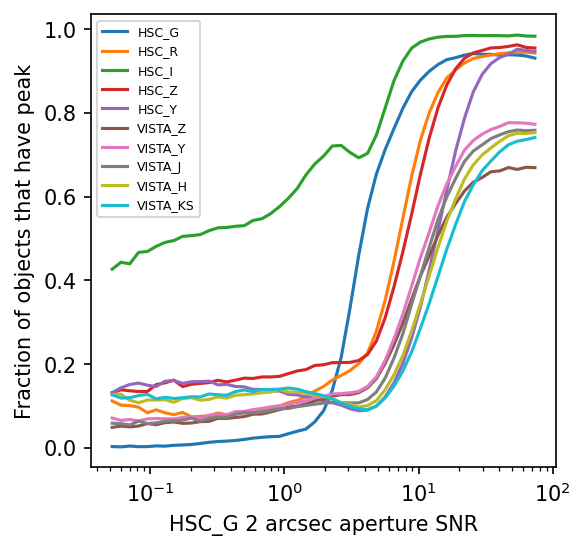

HSC_R


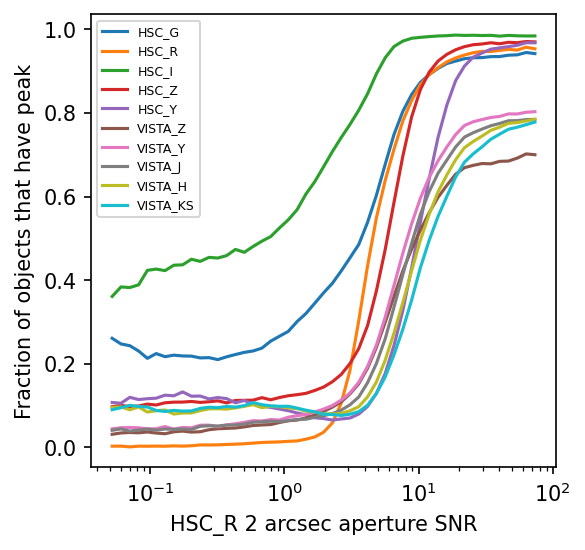

HSC_I


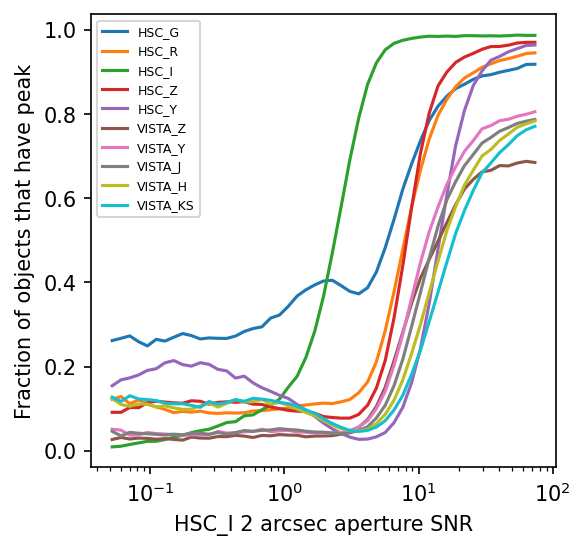

HSC_Z


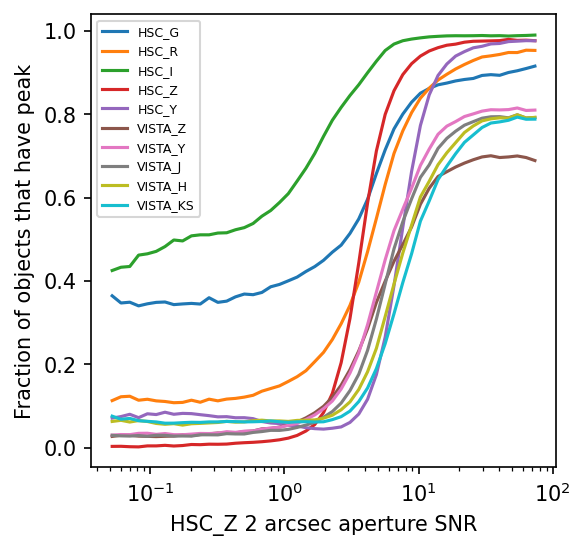

HSC_Y


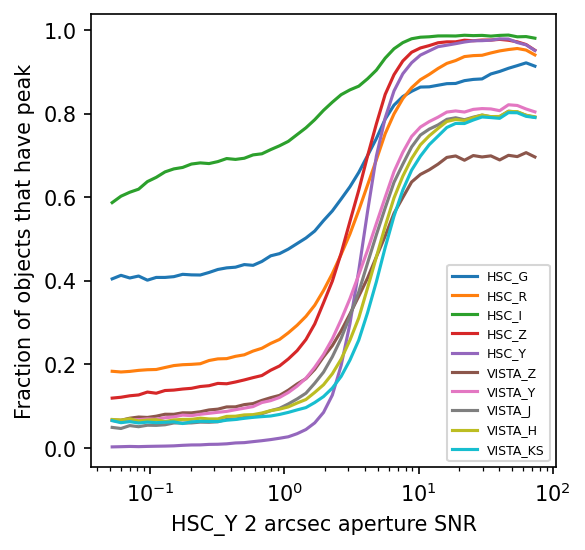

VISTA_Z


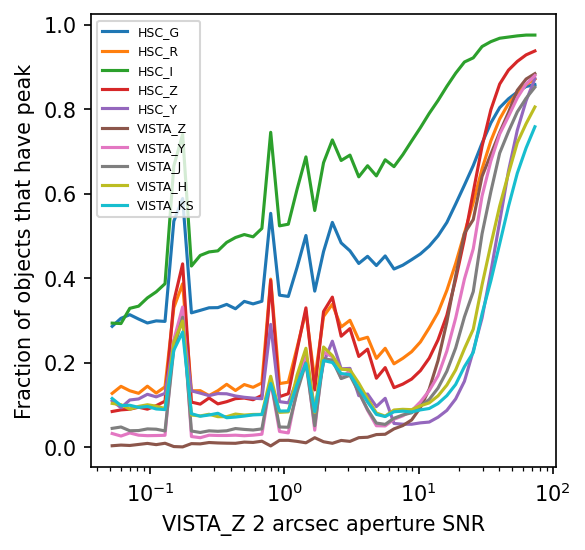

VISTA_Y


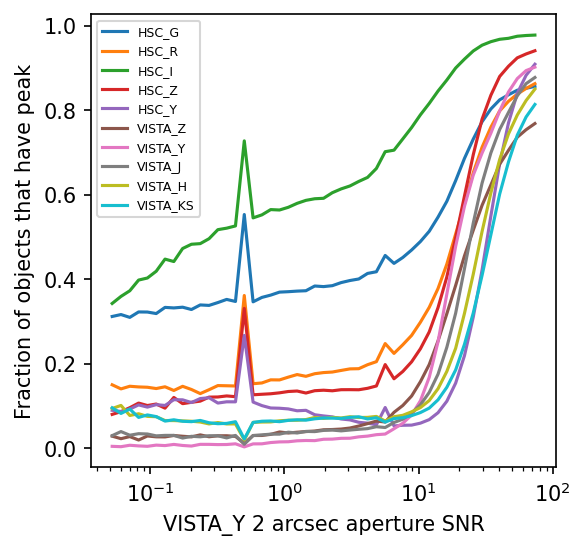

VISTA_J


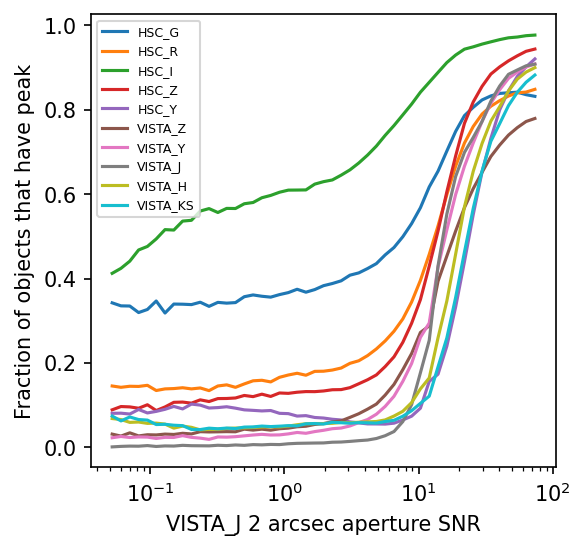

VISTA_H


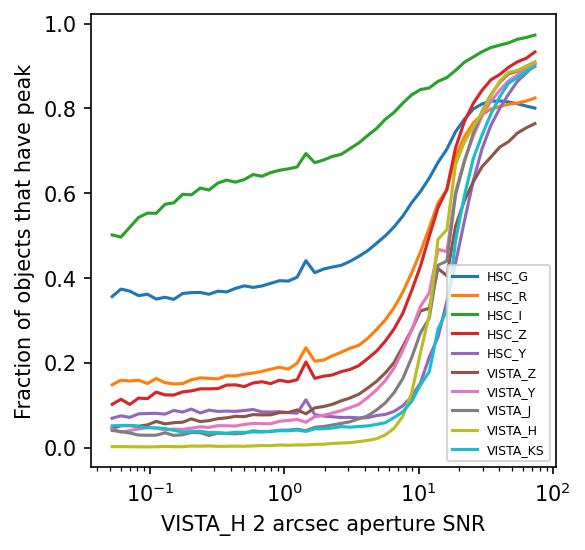

VISTA_KS


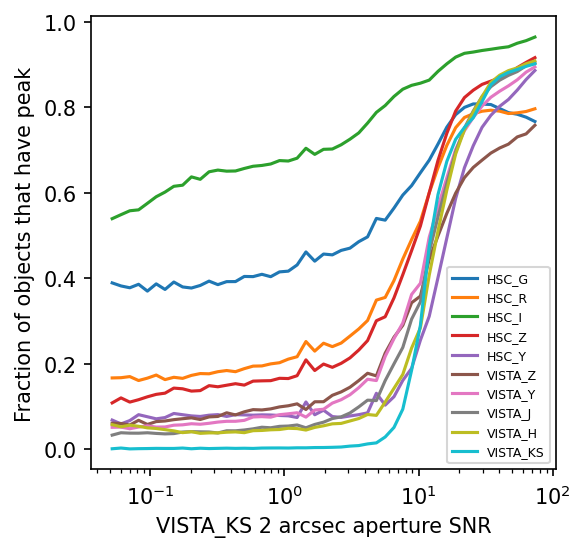

In [188]:
for s in 'grizyZYJHK':
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    if s.islower():
        band='HSC_'+s.upper()
    else:
        band='VISTA_'+s.replace('K','KS')
    print(band)
    fracs=Table()
    fracs['snr_bins']=logbins[:-1]
    f=fluxFromABMag(np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band.replace('KS','K'))].value.tolist()))
    ferr=fluxErrFromABMagErr(
        np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR'.format(band.replace('KS','K'))].value.tolist()),
        np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band.replace('KS','K'))].value.tolist()),
    )
    snr=f/ferr
    for s3 in 'grizyZYJHK':
        if s3.islower():
            band3='HSC_'+s3.upper()
        else:
            band3='VISTA_'+s3.replace('K','KS')
        #print(band)

        fracs[band3]=[np.sum(tab['HSC_G_M_MERGE_PEAK_{}'.format(band3)][
            (snr>logbins[n])&(snr<logbins[n+1])
        ])/np.sum((snr>logbins[n])&(snr<logbins[n+1])) 
                     for n in np.arange(len(logbins[:-1]))
                    ]
        ax.plot(fracs['snr_bins'],fracs[band3],label=band3)

    
    ax.legend(fontsize=6)
    ax.set_xscale('log')
    ax.set_xlabel('{} 2 arcsec aperture SNR'.format(band))
    ax.set_ylabel('Fraction of objects that have peak')
    plt.show()
    fig.savefig('./figs/peak_frac_plot_{}.png'.format(band))

HSC_G


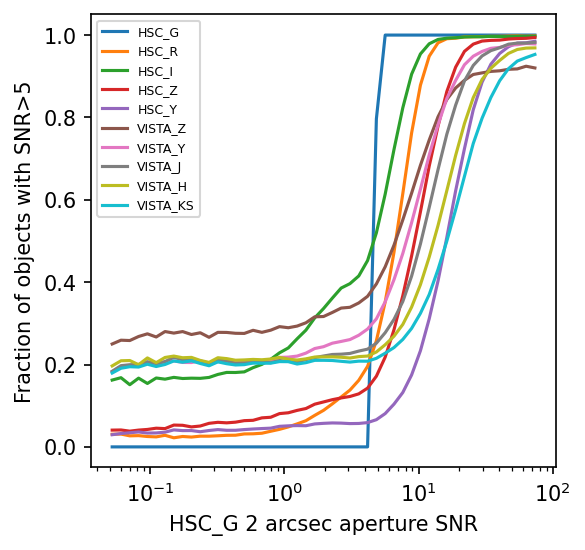

HSC_R


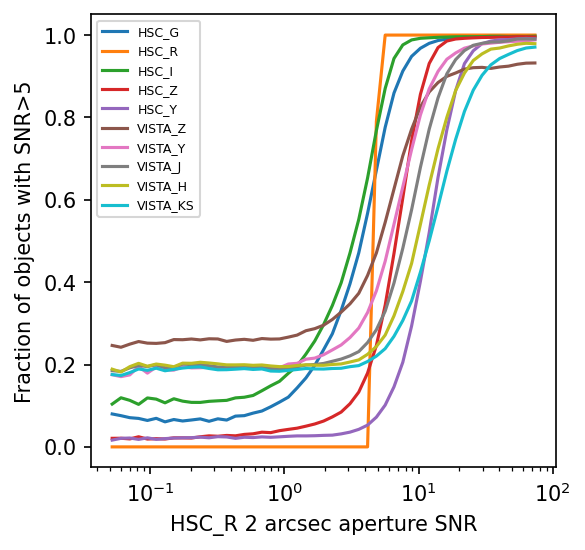

HSC_I


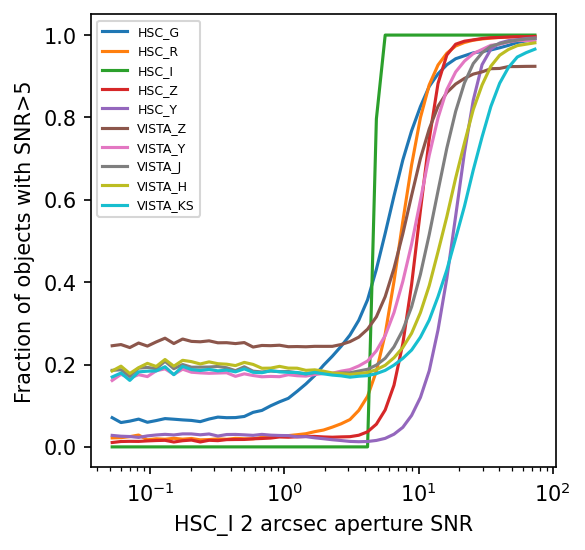

HSC_Z


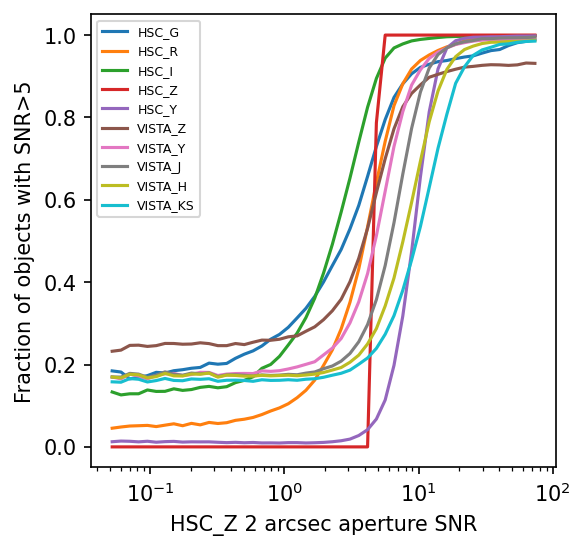

HSC_Y


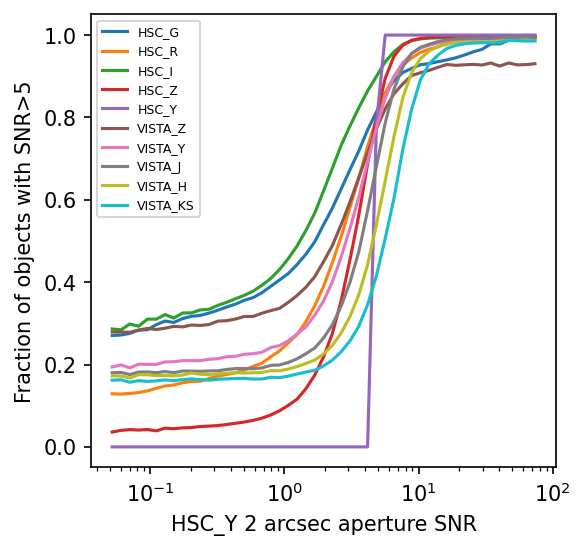

VISTA_Z


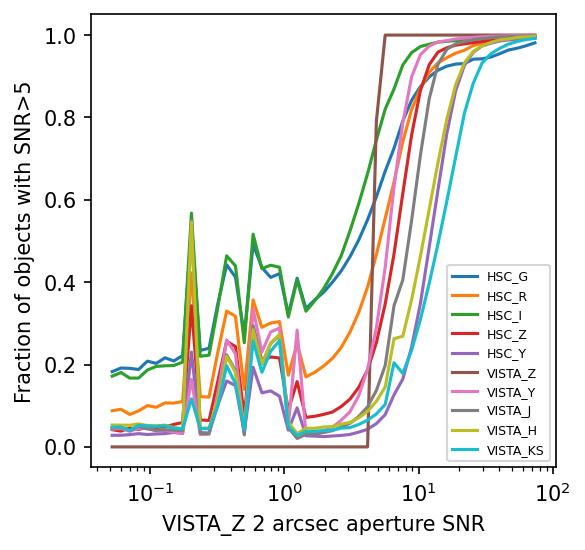

VISTA_Y


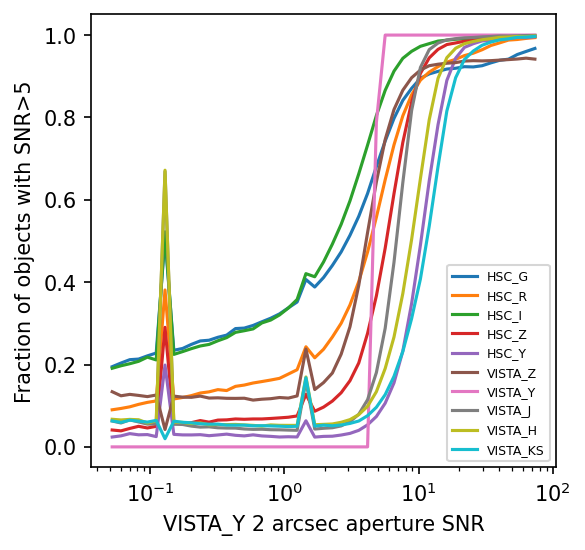

VISTA_J


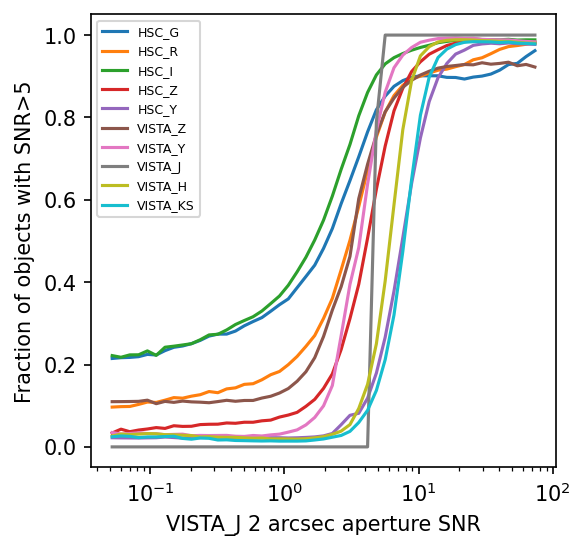

VISTA_H


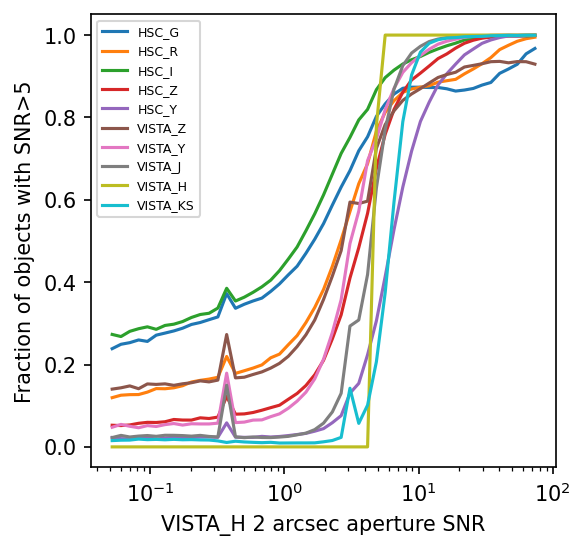

VISTA_KS


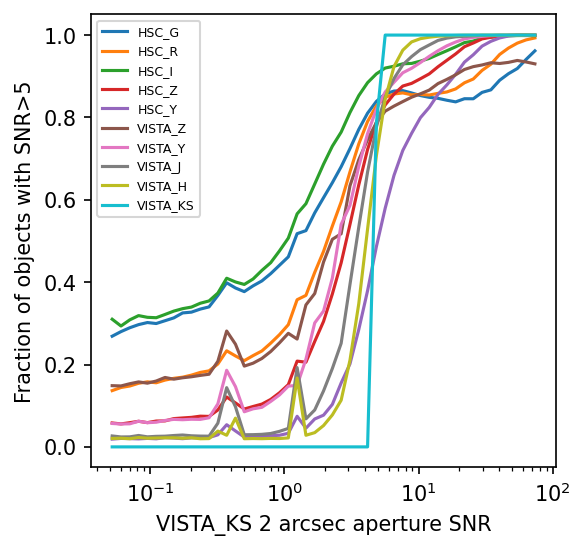

In [190]:
for s in 'grizyZYJHK':
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    if s.islower():
        band='HSC_'+s.upper()
    else:
        band='VISTA_'+s.replace('K','KS')
    print(band)
    fracs=Table()
    fracs['snr_bins']=logbins[:-1]
    f=fluxFromABMag(np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band.replace('KS','K'))].value.tolist()))
    ferr=fluxErrFromABMagErr(
        np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR'.format(band.replace('KS','K'))].value.tolist()),
        np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band.replace('KS','K'))].value.tolist()),
    )
    snr=f/ferr
    if 'VISTA' in band:
        snr/=4
    for s3 in 'grizyZYJHK':
        if s3.islower():
            band3='HSC_'+s3.upper()
        else:
            band3='VISTA_'+s3.replace('K','KS')
        #print(band)
        f3=fluxFromABMag(np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band3.replace('KS','K'))].value.tolist()))
        ferr3=fluxErrFromABMagErr(
            np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAGERR'.format(band3.replace('KS','K'))].value.tolist()),
            np.array(tab['{}_M_BASE_CIRCULARAPERTUREFLUX_6_0_MAG'.format(band3.replace('KS','K'))].value.tolist()),
        )
        snr3=f3/ferr3
        if 'VISTA' in band3:
            snr3/=4
        fracs[band3]=[np.sum(snr3[
            (snr>logbins[n])&(snr<logbins[n+1])
        ]>5)/np.sum((snr>logbins[n])&(snr<logbins[n+1])) 
                     for n in np.arange(len(logbins[:-1]))
                    ]
        ax.plot(fracs['snr_bins'],fracs[band3],label=band3)
    # for s2 in 'grizyZYJHK':
    #     if s2.islower():
    #         band2='HSC_'+s2.upper()
    #     else:
    #         band2='VISTA_'+s2.replace('K','KS')
    #     #print(band)
    #     ax.plot(fracs['snr_bins'],fracs[band2],label=band2)
    
    ax.legend(fontsize=6)
    ax.set_xscale('log')
    ax.set_xlabel('{} 2 arcsec aperture SNR'.format(band))
    ax.set_ylabel('Fraction of objects with SNR>5')
    plt.show()
    fig.savefig('./figs/snr_frac_plot_{}.png'.format(band))

In [114]:
s.islower()

True

In [156]:
!ls ~/Downloads/*.out

/Users/raphaelshirley/Downloads/my_zphot.out


In [161]:
t=Table.read('/Users/raphaelshirley/Downloads/my_zphot.out',format='ascii')

In [159]:
t[:5]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,float64,float64,float64
1,0.7364,0.7139,0.7635,0.7349,21.4116,8,1,0.3,90.553,48711000000000.0,43.283,10,-99.0,1000000000.0,-999,0.44,6.97561,25,116,2.91458,1023.0,5.035
2,0.8895,0.8793,0.8819,0.88,26.6168,5,0,0.0,99.995,24465000000000.0,43.7876,10,-99.0,1000000000.0,-999,0.72,66.5396,18,77,319.348,1023.0,8.624
3,0.78,0.7564,0.8036,0.78,24.1928,10,0,0.0,100.0,25174000000000.0,43.4366,10,-99.0,1000000000.0,-999,0.68,22.6035,8,107,309.634,1023.0,7.617
4,0.6826,0.6797,0.6803,0.68,784.07,4,1,0.3,100.0,14328.0,43.0817,10,-99.0,1000000000.0,-999,4.24,724.113,27,119,4961.29,1023.0,6.381
5,2.8369,2.8384,2.8412,2.84,303.012,6,1,0.1,99.989,461603000000000.0,46.8813,10,-99.0,1000000000.0,-999,1.76,137.127,18,97,2015.1,1023.0,1.3838


In [168]:
np.sum(np.isclose(t['col23'],0))

1337

(0.0, 6.0)

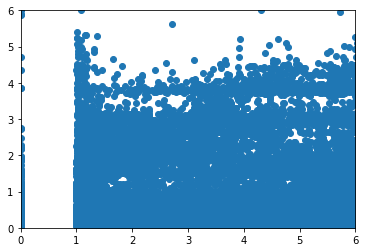

In [165]:
plt.scatter(t['col23'],t['col2'])
plt.xlim([0,6])
plt.ylim([0,6])

Text(0.5, 0, 'ZSPEC')

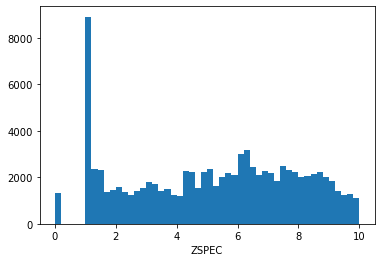

In [167]:
plt.hist(t['col23'],bins=50)
plt.xlabel('ZSPEC')